In [1]:
import feather
import os
import warnings
import numpy as np
import pandas as pd
import json
import codecs
import gc 

from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

seed = 666

%matplotlib inline
%load_ext autoreload
%autoreload 2

impot transformers and function that I've created in previous notebooks

In [2]:
import helpers

# Load data 


In [3]:
data_DIR = Path('/Users/xszpo/Google Drive/DataScience/Projects/201908_credit/'
                '01_data')

df_train = feather.read_dataframe(os.path.join(data_DIR, 'DS_loans_IN_train.feather')).reset_index(drop=True)
df_test = feather.read_dataframe(os.path.join(data_DIR, 'DS_loans_IN_test.feather')).reset_index(drop=True)

df_variables = feather.read_dataframe(os.path.join(data_DIR, 'variables_primary_selection.feather'))


In [4]:
with codecs.open(os.path.join(data_DIR, 'replacement_dictionary.json'),'r') as f:
    dict_repl=json.loads(f.read())
    

Do some repairs

Convert emp_length to numeric

In [5]:
replacement = {'emp_length':
                  {'< 1 year':0, '9 years':9, '3 years':3, '10+ years':11, '7 years':7,
                   '2 years':2, '4 years':4, '1 year':1, '8 years':8, '5 years':5, None:np.nan,
                   '6 years':6}}
df_train = df_train.replace(replacement)
df_test = df_test.replace(replacement)

repair text features

In [6]:
df_train.replace({'desc': {'': np.nan},'emp_title': {'': np.nan},'title': {'': np.nan}}, inplace=True)
df_train.fillna({'desc': 'novalue', 'emp_title': 'novalue', 'title': 'novalue'}, inplace=True)

df_test.replace({'desc': {'': np.nan},'emp_title': {'': np.nan},'title': {'': np.nan}}, inplace=True)
df_test.fillna({'desc': 'novalue', 'emp_title': 'novalue', 'title': 'novalue'}, inplace=True)



Select data category

`grade`,`sub_grade`,`int_rate` - are strong features which come from another model and they dominates my model.  I will drop it here and use it in blending step.


In [7]:
target = ['default']
exlude = ['loan_status','grade','int_rate','sub_grade']

features_all_text = ['emp_title','desc','title']
features_all_category = [i for i in df_train.select_dtypes(include=['object']).columns if i not in features_all_text+exlude]
features_all_numeric=  [i for i in df_train.select_dtypes(exclude=['object','datetime64[ns]']).columns if i not in target+exlude]
features_all_data =  list(df_train.select_dtypes(include=['datetime64[ns]']).columns)

print("Text features ({}): {} \n".format(len(features_all_text),", ".join(features_all_text)))
print("Category features ({}): {} \n".format(len(features_all_category),", ".join(features_all_category)))
print("Numeric features ({}): {} \n".format(len(features_all_numeric),", ".join(features_all_numeric)))
print("Datetime features ({}): {} \n".format(len(features_all_data),", ".join(features_all_data)))


Text features (3): emp_title, desc, title 

Category features (10): term, home_ownership, purpose, zip_code, addr_state, initial_list_status, application_type, verification_status_joint, sec_app_earliest_cr_line, disbursement_method 

Numeric features (73): loan_amnt, funded_amnt, installment, emp_length, annual_inc, dti, delinq_2yrs, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, collections_12_mths_ex_med, mths_since_last_major_derog, annual_inc_joint, dti_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_act_il, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, total_rev_hi_lim, inq_fi, total_cu_tl, inq_last_12m, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, mths_since_recent_inq, mths_s

Dataset is too big for my laptop, I reduce it ...

In [8]:
#df_train = df_train_.sample(100000, random_state=seed).reset_index(drop=True)
#df_test = df_test_.sample(50000, random_state=seed).reset_index(drop=True)

In [9]:
#!!! RESET INDEX
train_sample_size = 200000
train_sample_size_tune = int(train_sample_size/3)
test_sample_size = 50000
test_sample_size_tune = int(test_sample_size/3)

df_train = df_train.sample(train_sample_size, random_state=seed).reset_index(drop=True)
df_test = df_test.sample(test_sample_size, random_state=seed).reset_index(drop=True)

df_train_tune = df_train.sample(train_sample_size_tune, random_state=seed).reset_index(drop=True)
df_test_tune = df_test.sample(test_sample_size_tune, random_state=seed).reset_index(drop=True)

In [10]:
#del(df_train_, df_test_)
#gc.collect()

# Models

Some helper functions

In [32]:
def calculate_AUC_prop(pipe, dftrain = df_train, dftest = df_test, target= 'default'):
    y_pred_train = pipe.predict_proba(dftrain)[:,1]
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(dftrain['default'], y_pred_train, pos_label=1)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    print("Train AUC= %.3f"% roc_auc_train)
    
    y_pred_test = pipe.predict_proba(dftest)[:,1]
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(dftest['default'], y_pred_test, pos_label=1)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    print("Test AUC= %.3f"% roc_auc_test)    

    fig, ax = plt.subplots(figsize=(7,7))
    lw = 2
    ax.plot(fpr_train, tpr_train,  color='darkorange',
             lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
    ax.plot(fpr_test, tpr_test,  color='darkblue',
             lw=lw, label='Test ROC curve (area = %0.3f)' % roc_auc_test)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show
    
    return (roc_auc_train,roc_auc_test)

In [33]:
def calculate_AUC_prop_cat(pipe, dftrain, dftest, y_train, y_test):
    y_pred_train = pipe.predict_proba(dftrain)[:,1]
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    print("Train AUC= %.3f"% roc_auc_train)
    
    y_pred_test = pipe.predict_proba(dftest)[:,1]
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    print("Test AUC= %.3f"% roc_auc_test)    

    fig, ax = plt.subplots(figsize=(7,7))
    lw = 2
    ax.plot(fpr_train, tpr_train,  color='darkorange',
             lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
    ax.plot(fpr_test, tpr_test,  color='darkblue',
             lw=lw, label='Test ROC curve (area = %0.3f)' % roc_auc_test)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show
    
    return (roc_auc_train,roc_auc_test)

In [34]:
def calculate_AUC_blend(y_pred_train, y_pred_test, y_train, y_test):
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    print("Train AUC= %.3f"% roc_auc_train)
    
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    print("Test AUC= %.3f"% roc_auc_test)    

    fig, ax = plt.subplots(figsize=(7,7))
    lw = 2
    ax.plot(fpr_train, tpr_train,  color='darkorange',
             lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
    ax.plot(fpr_test, tpr_test,  color='darkblue',
             lw=lw, label='Test ROC curve (area = %0.3f)' % roc_auc_test)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show
    
    return (roc_auc_train,roc_auc_test)

In [14]:
def select_alpha_LR(alpha, Xtrain,Xtest,Ytrain,Ytest, pipe, model_name='logisticregression'):
    pipe.named_steps[model_name].C = alpha
    pipe.named_steps[model_name].fit(Xtrain, Ytrain)
    y_pred_train = pipe.named_steps[model_name].predict_proba(Xtrain)[:,1]
    y_pred_test = pipe.named_steps[model_name].predict_proba(Xtest)[:,1]

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Ytrain, y_pred_train, pos_label=1)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Ytest, y_pred_test, pos_label=1)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)

    nbr_features = len([i for i in zip(pipe.named_steps[model_name].coef_[0],
                        pipe.named_steps['columntransformer'].get_feature_names()) if i[0]>0])
    features = [i[1] for i in zip(pipe.named_steps[model_name].coef_[0],
                        pipe.named_steps['columntransformer'].get_feature_names()) if i[0]>0]

    return {'C':alpha,'roc_auc_train':roc_auc_train,'roc_auc_test':roc_auc_test, 
            'nbr_features':nbr_features} #,'features':features }



## Logistic LASSO regression

In [15]:
from itertools import compress
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from category_encoders import WOEEncoder, OneHotEncoder,TargetEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn import metrics
import eli5
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

seed = 666

In [16]:
manual_bins = {'acc_open_past_24mths': {'bins': [3, 9]},
 'int_rate': {'bins': [12, 20]},
 'avg_cur_bal': {'bins': [10000, 30000]},
 'dti': {'bins': [10, 33]},
 'emp_length': {},
 'annual_inc': {'bins': [125000]},
 'mo_sin_old_rev_tl_op': {},
 'bc_util': {},
 'mort_acc': {},
 'tot_cur_bal': {'bins': [20000, 130000]},
 'bc_open_to_buy': {'bins': [5000, 2000]},
 'mths_since_recent_bc': {},
 'total_bc_limit': {'bins': [30000, 60000]},
 'loan_amnt': {}}

In [17]:
import helpers

In [18]:
pipe_212_lasso = make_pipeline(
    ColumnTransformer([
        ('numeric', helpers.DecisionTreeDiscretizer_DF(bins = manual_bins,
            max_depth = 3, min_samples_prc_leaf=0.05),features_all_numeric),
        ('category',helpers.PassThroughOrReplace(fillna=True, replace_dict=dict_repl),features_all_category)
    ]),
    WOEEncoder(random_state=seed),
    LogisticRegression(random_state=seed, C=0.05, penalty='l1')
    )

In [19]:
%%time
pipe_212_lasso.fit(df_train_tune, df_train_tune.default)

CPU times: user 13.5 s, sys: 1.1 s, total: 14.6 s
Wall time: 14.8 s


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  DecisionTreeDiscretizer_DF(bins={'acc_open_past_24mths': {'bins': [3,
                                                                                                                     9]},
                                                                                   'annual_inc': {'bins': [125000]},
                                                                                   'avg_cur_bal': {'bins': [10000,
                                                                                                            30000]},
                                                                                   'bc_open_to_buy': {'b

In [20]:
_x_tr = pipe_212_lasso.named_steps['woeencoder'].transform(pipe_212_lasso.named_steps['columntransformer'].transform(df_train_tune))
_x_tst = pipe_212_lasso.named_steps['woeencoder'].transform(pipe_212_lasso.named_steps['columntransformer'].transform(df_test_tune))


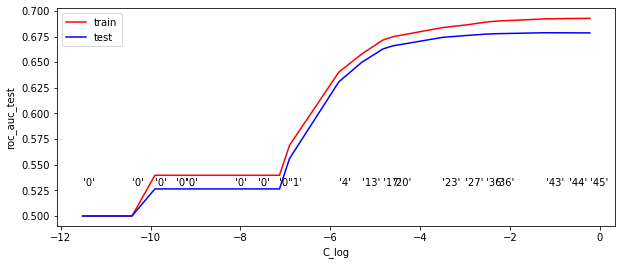

CPU times: user 17.9 s, sys: 2.21 s, total: 20.1 s
Wall time: 19.9 s


In [24]:
%%time

list_alpha = list((np.array([1/(10**i) for i in range(1,6)]).reshape(-1,1)*np.array([8,5,3,1]).reshape(1,-1)).reshape(-1))

wyniki = [select_alpha_LR(alpha = i, Xtrain=_x_tr,Xtest=_x_tst,Ytrain=df_train_tune['default'],Ytest=df_test_tune['default'],
             pipe = pipe_212_lasso, model_name='logisticregression') for i in list_alpha]

wyn = pd.DataFrame(wyniki)
wyn['C_log'] = np.log(wyn.C)

fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x='C_log', 
             y='roc_auc_train',
             color='r',
             data=wyn,
             ax=ax)
sns.lineplot(x='C_log', 
             y='roc_auc_test', 
             color='b',
             data=wyn,
             ax=ax)   
ax.legend(['train', 'test'], facecolor='w')
[ax.text(p[0], 0.53, "'"+str(p[2])+"'", color='black') for p in zip(wyn.C_log.to_list(), wyn.roc_auc_train.to_list(), wyn.nbr_features.to_list())]

plt.show()
          

In [25]:
wyn.query("C_log <0 & C_log>-6")

,C,roc_auc_train,roc_auc_test,nbr_features,C_log
0,0.800,0.692734,0.678531,45,-0.223144
1,0.500,0.692555,0.678608,44,-0.693147
2,0.300,0.692209,0.678694,43,-1.203973
3,0.100,0.690045,0.677758,36,-2.302585
4,0.080,0.689149,0.677385,36,-2.525729
5,0.050,0.686203,0.675943,27,-2.995732
6,0.030,0.683694,0.674139,23,-3.506558
7,0.010,0.674819,0.665932,20,-4.605170
8,0.008,0.671617,0.662898,17,-4.828314
9,0.005,0.658014,0.649920,13,-5.298317


In [40]:
pipe_212_lasso = make_pipeline(
    ColumnTransformer([
        ('numeric', helpers.DecisionTreeDiscretizer_DF(bins = manual_bins,
            max_depth = 3, min_samples_prc_leaf=0.05),features_all_numeric),
        ('category',helpers.PassThroughOrReplace(fillna=True, replace_dict=dict_repl),features_all_category)
    ]),
    WOEEncoder(random_state=seed),
    LogisticRegression(random_state=seed, C=0.01, penalty='l1')
    )

In [41]:
%%time
pipe_212_lasso.fit(df_train, df_train.default)

CPU times: user 40.8 s, sys: 3.83 s, total: 44.6 s
Wall time: 47.2 s


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  DecisionTreeDiscretizer_DF(bins={'acc_open_past_24mths': {'bins': [3,
                                                                                                                     9]},
                                                                                   'annual_inc': {'bins': [125000]},
                                                                                   'avg_cur_bal': {'bins': [10000,
                                                                                                            30000]},
                                                                                   'bc_open_to_buy': {'b

In [42]:
len([i for i in zip(pipe_212_lasso.named_steps['logisticregression'].coef_[0],
                    pipe_212_lasso.named_steps['columntransformer'].get_feature_names()) if i[0]>0])

24

Train AUC= 0.679
Test AUC= 0.678
CPU times: user 16 s, sys: 1.43 s, total: 17.4 s
Wall time: 18.1 s


(0.6785377846539303, 0.6783104479031097)

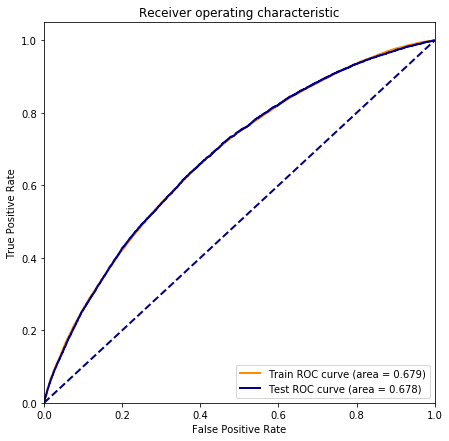

In [43]:
%%time
calculate_AUC_prop(pipe_212_lasso, dftrain = df_train, dftest = df_test)

In [44]:
eli5.show_weights(pipe_212_lasso.named_steps['logisticregression'], 
                  feature_names = pipe_212_lasso.named_steps['columntransformer'].get_feature_names(),
                 top=31)

Weight?,Feature
+1.034,category__term
+0.691,numeric__emp_length
+0.668,category__purpose
+0.641,numeric__inq_last_6mths
+0.606,numeric__tot_hi_cred_lim
+0.520,category__home_ownership
+0.493,numeric__dti
+0.492,numeric__acc_open_past_24mths
+0.486,numeric__total_rev_hi_lim
+0.453,numeric__num_tl_op_past_12m


## Neutral network

In [45]:
#df_train = df_train_.sample(300000, random_state=seed).reset_index(drop=True)
#df_test = df_test_.sample(100000, random_state=seed).reset_index(drop=True)

In [46]:
gc.collect()

5419

In [47]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn import metrics
import eli5

from category_encoders import OrdinalEncoder
import helpers

seed = 666

In [48]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [49]:
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, InputLayer, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.initializers import glorot_normal
from keras.engine.input_layer import Input
from keras.optimizers import Adam, SGD

opt = SGD(lr=0.01, momentum=0.9)

# For custom metrics
import keras.backend as K


def create_model():
    model_in = Input(shape=(83,), dtype='float32', sparse=False)
    out = Dense(192, activation='relu')(model_in)
    out = Dropout(0.2)(out)
    out = Dense(64, activation='relu')(out)
    out = Dropout(0.2)(out)
    out = Dense(1, activation='sigmoid')(out)
    model = Model(model_in, out)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', auroc])
    return model

Using TensorFlow backend.


In [50]:
exclude = []
pipe_221_nn = make_pipeline(
    ColumnTransformer([
        ('numeric', helpers.PassThroughOrReplace(fillna=True, replace_dict=dict_repl),
         [i for i in features_all_numeric if i not in exclude]),
        ('category',TargetEncoder(),[i for i in features_all_category if i not in exclude])
    ]),
    StandardScaler(),
    KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=1)
    )

In [52]:
%%time
pipe_221_nn.fit(df_train, df_train.default)

Epoch 1/10
200000/200000 [==============================] - 11s 54us/step - loss: 0.4375 - acc: 0.8250 - auroc: 0.6734
Epoch 2/10
200000/200000 [==============================] - 13s 65us/step - loss: 0.4284 - acc: 0.8259 - auroc: 0.6937
Epoch 3/10
200000/200000 [==============================] - 15s 73us/step - loss: 0.4265 - acc: 0.8255 - auroc: 0.6986
Epoch 4/10
200000/200000 [==============================] - 12s 59us/step - loss: 0.4252 - acc: 0.8261 - auroc: 0.7029
Epoch 5/10
200000/200000 [==============================] - 11s 56us/step - loss: 0.4241 - acc: 0.8262 - auroc: 0.7056
Epoch 6/10
200000/200000 [==============================] - 14s 70us/step - loss: 0.4230 - acc: 0.8261 - auroc: 0.7070 0s - loss: 0.4227 - acc: 0.8264
Epoch 7/10
200000/200000 [==============================] - 14s 69us/step - loss: 0.4226 - acc: 0.8263 - auroc: 0.7080
Epoch 8/10
200000/200000 [==============================] - 14s 68us/step - loss: 0.4220 - acc: 0.8260 - auroc: 0.7098
Epoch 9/10
20000

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  PassThroughOrReplace(fillna=True,
                                                                       replace_dict={'zip_code': {'007xx': 3,
                                                                                                  '008xx': 4,
                                                                                                  '009xx': 2,
                                                                                                  '010xx': 1,
                                                                                                  '011xx': 0,
                                                             

NOTE - need more data to train and better hardware, nevertheless I think that data doest have the information to prepare good predictions 

200000/200000 [==============================] - 2s 8us/step
Train AUC= 0.724
50000/50000 [==============================] - 0s 9us/step
Test AUC= 0.700
CPU times: user 3.39 s, sys: 488 ms, total: 3.88 s
Wall time: 3.21 s


(0.7240470798550231, 0.7003267284424176)

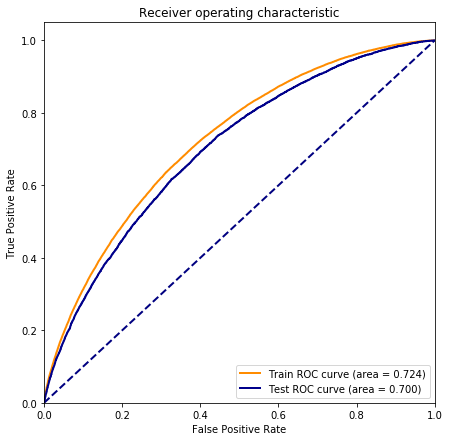

In [53]:
%%time
calculate_AUC_prop(pipe_221_nn, dftrain = df_train, dftest = df_test)

## CatBoost + Scikit-Optimize

Scikit-Optimize part is in another notebook: Google Collab (GPU) `05_model_collab_GPU.ipynb`

```
CatBoost took 405.34 seconds,  candidates checked: 1, best CV score: 0.700 ± 0.001
Best parameters:
{'bagging_temperature': 0.5931923511642098,
 'border_count': 52,
 'depth': 6,
 'iterations': 70,
 'l2_leaf_reg': 14,
 'learning_rate': 0.9473066099743538,
 'random_strength': 7.63131053187394e-07,
 'scale_pos_weight': 1.3052104983649078}
 ```

In [54]:
from catboost import CatBoostClassifier, Pool
from sklearn import metrics


In [55]:
df_train_c = df_train.copy()
df_test_c = df_test.copy()

In [56]:
# convert text to category 
for col in features_all_category:
    df_train_c[col] = df_train_c[col].replace([' '],['nocat']).fillna('nocat').astype('category')

for col in features_all_category:
    df_test_c[col] = df_test_c[col].replace([' '],['nocat']).fillna('nocat').astype('category')


In [57]:
train_pool = Pool(data=df_train_c[features_all_category+features_all_numeric], 
                  label=df_train_c.default.to_list(), cat_features=features_all_category)

test_pool = Pool(data=df_test_c[features_all_category+features_all_numeric],
                 label=df_test_c.default.to_list(), cat_features=features_all_category)


params from Google Collab - `05_model_collab_GPU.ipynb`

In [58]:
param = {'bagging_temperature': 0.5434030676903125,
 'depth': 7,
 'iterations': 154,
 'l2_leaf_reg': 25,
 'learning_rate': 0.04447541043186938,
 'random_strength': 3.245977736555784e-09,
 'scale_pos_weight': 0.5750700246521092}

In [59]:
cat_cls = CatBoostClassifier(**param, loss_function='Logloss',
                         custom_metric = ['Logloss', 'AUC'],
                         cat_features = features_all_category,
                         verbose = False)

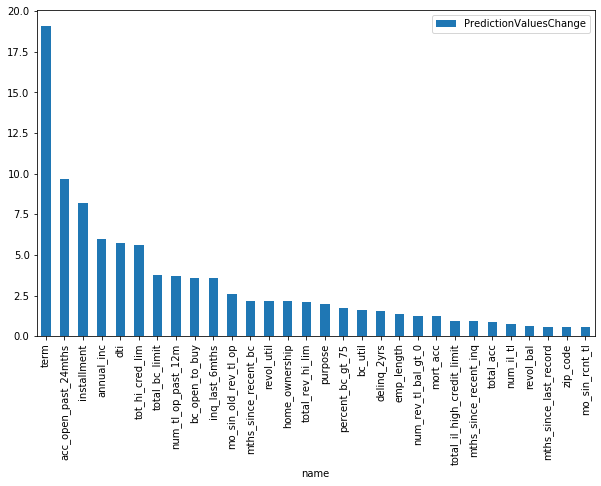

In [111]:
import operator
fi = []
for i in zip(train_pool.get_feature_names(),cat_cls.get_feature_importance(type='PredictionValuesChange')):
    fi += [{"name":i[0],"PredictionValuesChange":i[1]}]
    
pd.DataFrame(fi).sort_values("PredictionValuesChange",ascending=False).head(30).plot.bar(x='name', y='PredictionValuesChange', figsize =(10,6))


In [60]:
%%time

cat_cls.fit(train_pool)

CPU times: user 1min 51s, sys: 7.35 s, total: 1min 59s
Wall time: 41.1 s


Train AUC= 0.711
Test AUC= 0.701


(0.71132563060825, 0.7010904231669306)

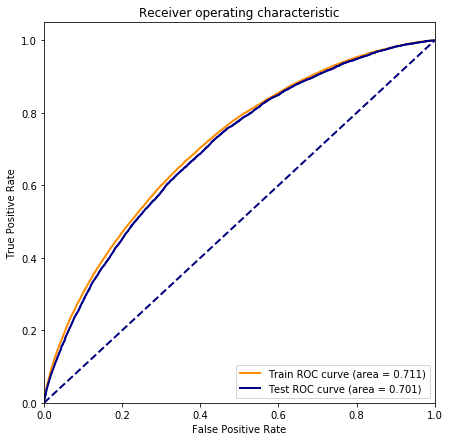

In [61]:
calculate_AUC_prop_cat(cat_cls, train_pool, test_pool, df_train.default.to_list(), df_test.default.to_list())

NOTE - need more data to train and better hardware, nevertheless I think that data doest have the information to prepare good predictions 

# Blend

In [62]:
LC_model = df_train.groupby(['sub_grade'])[['default']].mean()
def_rate_by_sub_grade= {}
for i in LC_model.itertuples():
    def_rate_by_sub_grade[i.Index]= i.default
    
def LC_model_predict(df):
    return df.sub_grade.replace(def_rate_by_sub_grade).to_list()



In [63]:
%%time
tr_lc_model = LC_model_predict(df_train)
tr_212 = pipe_212_lasso.predict_proba(df_train)[:,1]
tr_221 = pipe_221_nn.predict_proba(df_train)[:,1]
tr_cat = cat_cls.predict_proba(train_pool)[:,1]

te_lc_model = LC_model_predict(df_test)
te_212 = pipe_212_lasso.predict_proba(df_test)[:,1]
te_221 = pipe_221_nn.predict_proba(df_test)[:,1]
te_cat = cat_cls.predict_proba(test_pool)[:,1]

50000/50000 [==============================] - 0s 7us/step
CPU times: user 19.8 s, sys: 1.98 s, total: 21.8 s
Wall time: 21.3 s


In [64]:
tr_lc_model = LC_model_predict(df_train)
te_lc_model = LC_model_predict(df_test)



In [65]:
y_train_pred = np.array([tr_lc_model,tr_212,tr_221, tr_cat])
y_test_pred = np.array([te_lc_model,te_212,te_221, te_cat])


In [66]:
from scipy.special import softmax
from scipy.optimize import minimize


def roc_optimaize(x):
    
    x=softmax(np.abs(x))
    blend_weights = x.reshape(-1,1)
    #y_train_pred_blend = (y_train_pred * blend_weights).sum(axis=0)
    y_test_pred_blend = (y_test_pred * blend_weights).sum(axis=0)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(df_test.default.to_list(), y_test_pred_blend, pos_label=1)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    return roc_auc_test*(-1)


nbr = y_train_pred.shape[0]
wsp = [None for i in range(nbr)]
for i in range(nbr):
    wsp[i] = round(1/nbr,4)

x0 = np.array(wsp)


In [67]:
#https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
res = minimize(roc_optimaize, x0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.711485
         Iterations: 153
         Function evaluations: 334


In [68]:
blend_weights = np.array(softmax(np.abs(res.x))).reshape(-1,1)

In [69]:
print(np.round(blend_weights,4))

[[0.3127]
 [0.077 ]
 [0.3843]
 [0.226 ]]


In [70]:
y_train_pred_blend = (y_train_pred * blend_weights).sum(axis=0)
y_test_pred_blend = (y_test_pred * blend_weights).sum(axis=0)

Train AUC= 0.725
Test AUC= 0.711


(0.7248367156946158, 0.711484927488223)

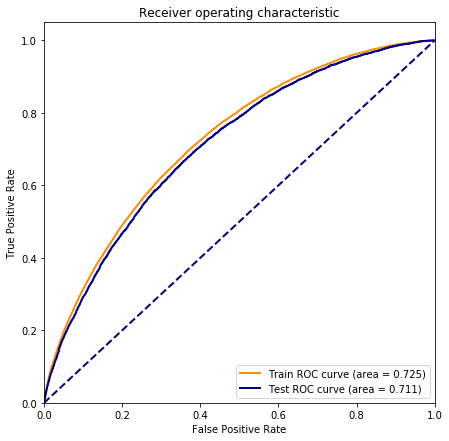

In [71]:
calculate_AUC_blend(y_train_pred_blend, y_test_pred_blend, df_train.default.to_list(), df_test.default.to_list())
